# Random Linear Classifier with Cross-Validation

This notebook implements the complete machine learning pipeline:
- Train/Test split for final evaluation
- Cross-validation for hyperparameter optimization (finding best K)
- Proper evaluation of both the learning algorithm and the final classifier

## Key Concepts:
- **Classifier Performance**: How well does the final model perform?
- **Learning Algorithm Performance**: How good is our algorithm at finding good classifiers?
- **Cross-Validation**: Technique to optimize hyperparameters without using test data

In [1]:
# Import required libraries for advanced machine learning with cross-validation
import numpy as np                                           # Mathematical operations
import matplotlib.pyplot as plt                              # Plotting and visualization
from sklearn.model_selection import train_test_split, KFold  # Data splitting and cross-validation

In [2]:
# Set random seed for reproducible results
# Critical for cross-validation - ensures consistent results across runs
# This makes our experiments reproducible and results comparable
np.random.seed(42)

## Data Generation and Train/Test Split

In [ ]:
# Generate the same synthetic data as before

#np.random.normal(mean,standard deviation,number of samples)
# Dogs: shorter whiskers (5), higher ear flappiness (8)
dog_whisker_length = np.random.normal(5, 1, 10)   
dog_ear_flappiness_index = np.random.normal(8, 1, 10)

# Cats: longer whiskers (8), lower ear flappiness (5)
cat_whisker_length = np.random.normal(8, 1, 10)
cat_ear_flappiness_index = np.random.normal(5, 1, 10)

# Combine all data into feature matrix X and label vector y
X = np.vstack([
    np.column_stack([dog_whisker_length, dog_ear_flappiness_index]),  # Dog features
    np.column_stack([cat_whisker_length, cat_ear_flappiness_index])   # Cat features
])
y = np.hstack([np.zeros(10), np.ones(10)])  # 0=dog, 1=cat

# Split into train/test FIRST (before cross-validation)
# Test set is held out completely - never used for training or hyperparameter tuning
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"📊 Data split complete:")
print(f"Training data: {X_train.shape[0]} points (for algorithm development)")
print(f"Test data: {X_test.shape[0]} points (for final evaluation only)")

Training data: 16 points
Test data: 4 points


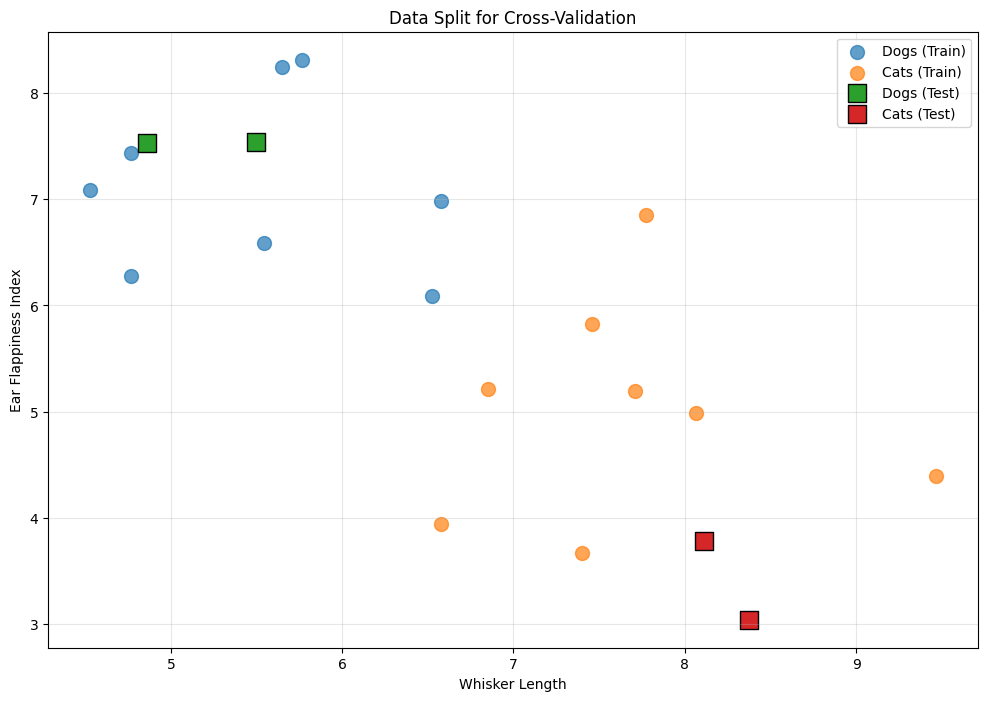

In [4]:
# Visualize the split
train_dogs = X_train[y_train == 0]
train_cats = X_train[y_train == 1]
test_dogs = X_test[y_test == 0]
test_cats = X_test[y_test == 1]

plt.figure(figsize=(12, 8))
plt.scatter(train_dogs[:, 0], train_dogs[:, 1], label='Dogs (Train)', alpha=0.7, s=100)
plt.scatter(train_cats[:, 0], train_cats[:, 1], label='Cats (Train)', alpha=0.7, s=100)
plt.scatter(test_dogs[:, 0], test_dogs[:, 1], label='Dogs (Test)', s=150, marker='s', edgecolors='black')
plt.scatter(test_cats[:, 0], test_cats[:, 1], label='Cats (Test)', s=150, marker='s', edgecolors='black')
plt.xlabel('Whisker Length')
plt.ylabel('Ear Flappiness Index')
plt.title('Data Split for Cross-Validation')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## Algorithm Implementation

In [5]:
def compute_error(theta, theta_0, dog_data, cat_data):
    """Compute classification error"""
    error = 0
    
    # Dogs should be classified as +1
    for i in range(dog_data.shape[0]):
        if np.dot(theta, dog_data[i]) + theta_0 < 0:
            error += 1
    
    # Cats should be classified as -1
    for i in range(cat_data.shape[0]):
        if np.dot(theta, cat_data[i]) + theta_0 > 0:
            error += 1
            
    return error

def random_linear_classifier(dog_data, cat_data, k, d):
    """Random Linear Classifier Algorithm"""
    best_error = float('inf')
    best_theta = None
    best_theta_0 = None
    
    for i in range(k):
        theta = np.random.normal(0, 1, d)
        theta_0 = np.random.normal(0, 1)
        
        current_error = compute_error(theta, theta_0, dog_data, cat_data)
        
        if current_error < best_error:
            best_error = current_error
            best_theta = theta.copy()
            best_theta_0 = theta_0
    
    return best_theta, best_theta_0

## Cross-Validation for Hyperparameter Optimization

In [6]:
def k_fold_cross_validation(X_train, y_train, k_values, n_splits=5):
    """
    Perform k-fold cross-validation to find the best K value.
    
    Parameters:
    - X_train: training features
    - y_train: training labels
    - k_values: list of K values to try
    - n_splits: number of folds for cross-validation
    
    Returns:
    - best_k: optimal K value
    - average_errors: cross-validation errors for each K
    """
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    average_errors = []
    
    for k in k_values:
        fold_errors = []
        
        # Perform k-fold cross-validation
        for train_idx, val_idx in kfold.split(X_train):
            # Split into train and validation for this fold
            X_fold_train, X_fold_val = X_train[train_idx], X_train[val_idx]
            y_fold_train, y_fold_val = y_train[train_idx], y_train[val_idx]
            
            # Separate by class for this fold
            fold_train_dogs = X_fold_train[y_fold_train == 0]
            fold_train_cats = X_fold_train[y_fold_train == 1]
            fold_val_dogs = X_fold_val[y_fold_val == 0]
            fold_val_cats = X_fold_val[y_fold_val == 1]
            
            # Train classifier on fold training data
            if len(fold_train_dogs) > 0 and len(fold_train_cats) > 0:
                theta, theta_0 = random_linear_classifier(fold_train_dogs, fold_train_cats, k, 2)
                
                # Evaluate on fold validation data
                if len(fold_val_dogs) > 0 or len(fold_val_cats) > 0:
                    error = compute_error(theta, theta_0, fold_val_dogs, fold_val_cats)
                    total_val_points = len(fold_val_dogs) + len(fold_val_cats)
                    fold_errors.append(error / total_val_points if total_val_points > 0 else 0)
        
        # Calculate average error for this K
        avg_error = np.mean(fold_errors) if fold_errors else float('inf')
        average_errors.append(avg_error)
        print(f"K={k}: Average CV Error = {avg_error:.4f}")
    
    # Find best K (minimum error)
    best_k_idx = np.argmin(average_errors)
    best_k = k_values[best_k_idx]
    
    return best_k, average_errors

In [7]:
# Define different K values to test
# K = number of random lines our algorithm will try
# We don't know which is best, so we'll test several options
k_values = [10, 50, 100, 200, 350]

# 🔬 HYPERPARAMETER OPTIMIZATION: Find the best K using cross-validation
# This is the scientific way to choose algorithm settings!
print("🔍 Performing 5-fold cross-validation to find optimal K...")
print("This will test each K value using 5 different train/validation splits")
best_k, cv_errors = k_fold_cross_validation(X_train, y_train, k_values, n_splits=5)

print(f"\n🎉 Cross-validation complete!")
print(f"🏆 Best K value: {best_k}")
print(f"📊 Best CV error: {min(cv_errors):.4f}")
print(f"\n💡 This means trying {best_k} random lines gives the best results!")

🔍 Performing 5-fold cross-validation to find optimal K...
This will test each K value using 5 different train/validation splits
K=10: Average CV Error = 0.2667
K=50: Average CV Error = 0.0667
K=100: Average CV Error = 0.0000
K=200: Average CV Error = 0.0667
K=350: Average CV Error = 0.0667

🎉 Cross-validation complete!
🏆 Best K value: 100
📊 Best CV error: 0.0000

💡 This means trying 100 random lines gives the best results!


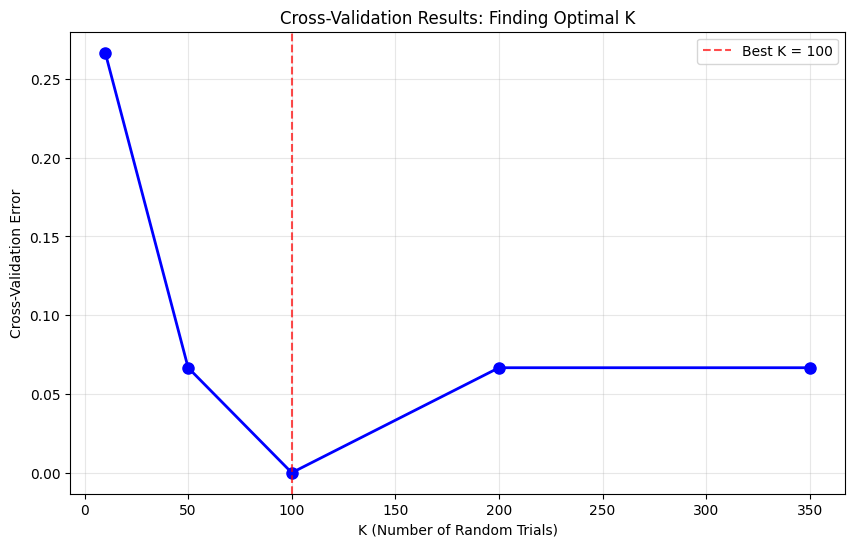

In [8]:
# Plot cross-validation results
plt.figure(figsize=(10, 6))
plt.plot(k_values, cv_errors, 'bo-', linewidth=2, markersize=8)
plt.axvline(x=best_k, color='red', linestyle='--', alpha=0.7, label=f'Best K = {best_k}')
plt.xlabel('K (Number of Random Trials)')
plt.ylabel('Cross-Validation Error')
plt.title('Cross-Validation Results: Finding Optimal K')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

## Train Final Model with Optimal K

In [9]:
# Train final model using best K on all training data
final_train_dogs = X_train[y_train == 0]
final_train_cats = X_train[y_train == 1]

print(f"Training final model with K = {best_k}...")
best_theta, best_theta_0 = random_linear_classifier(final_train_dogs, final_train_cats, best_k, 2)

print(f"Final model parameters:")
print(f"θ₁ = {best_theta[0]:.4f}")
print(f"θ₂ = {best_theta[1]:.4f}")
print(f"θ₀ = {best_theta_0:.4f}")

Training final model with K = 100...
Final model parameters:
θ₁ = -0.9033
θ₂ = 0.9341
θ₀ = 0.4335


## Final Evaluation

In [10]:
# Calculate training error
training_error = compute_error(best_theta, best_theta_0, final_train_dogs, final_train_cats)
training_total = len(final_train_dogs) + len(final_train_cats)
training_accuracy = (training_total - training_error) / training_total * 100

print(f"Training Error: {training_error}/{training_total}")
print(f"Training Accuracy: {training_accuracy:.1f}%")

# Calculate test error
final_test_dogs = X_test[y_test == 0]
final_test_cats = X_test[y_test == 1]

test_error = compute_error(best_theta, best_theta_0, final_test_dogs, final_test_cats)
test_total = len(final_test_dogs) + len(final_test_cats)
test_accuracy = (test_total - test_error) / test_total * 100

print(f"\nTest Error: {test_error}/{test_total}")
print(f"Test Accuracy: {test_accuracy:.1f}%")

Training Error: 0/16
Training Accuracy: 100.0%

Test Error: 0/4
Test Accuracy: 100.0%


## Final Visualization

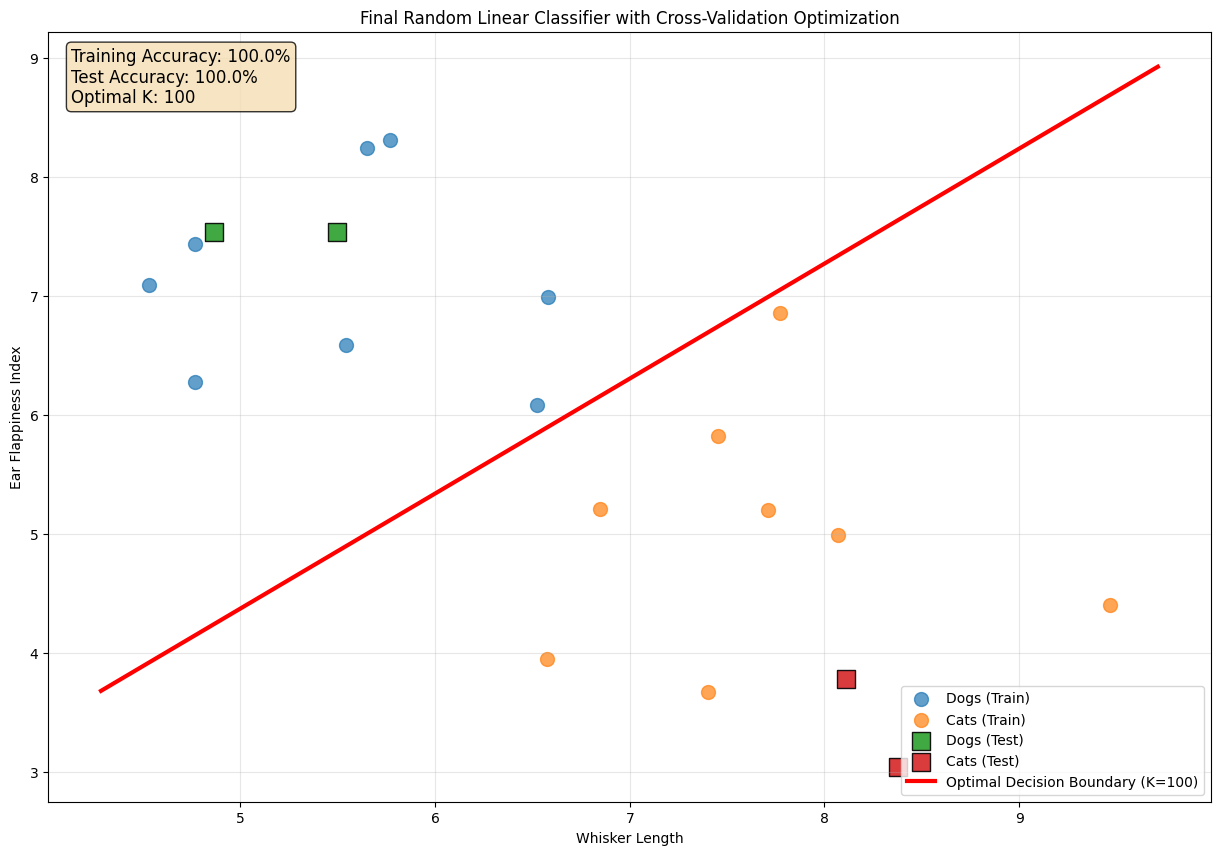


Final Decision Boundary Equation:
-0.9033x₁ + 0.9341x₂ + 0.4335 = 0


In [11]:
# Create comprehensive visualization
plt.figure(figsize=(15, 10))

# Training data
plt.scatter(final_train_dogs[:, 0], final_train_dogs[:, 1], 
           label='Dogs (Train)', alpha=0.7, s=100, marker='o')
plt.scatter(final_train_cats[:, 0], final_train_cats[:, 1], 
           label='Cats (Train)', alpha=0.7, s=100, marker='o')

# Test data
plt.scatter(final_test_dogs[:, 0], final_test_dogs[:, 1], 
           label='Dogs (Test)', alpha=0.9, s=150, marker='s', edgecolors='black')
plt.scatter(final_test_cats[:, 0], final_test_cats[:, 1], 
           label='Cats (Test)', alpha=0.9, s=150, marker='s', edgecolors='black')

# Decision boundary
x_min, x_max = plt.xlim()
x_line = np.linspace(x_min, x_max, 100)
y_line = -(best_theta[0] * x_line + best_theta_0) / best_theta[1]

plt.plot(x_line, y_line, 'r-', linewidth=3, 
         label=f'Optimal Decision Boundary (K={best_k})')

plt.xlabel('Whisker Length')
plt.ylabel('Ear Flappiness Index')
plt.title('Final Random Linear Classifier with Cross-Validation Optimization')
plt.legend()
plt.grid(True, alpha=0.3)

# Add text box with results
textstr = f'Training Accuracy: {training_accuracy:.1f}%\nTest Accuracy: {test_accuracy:.1f}%\nOptimal K: {best_k}'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
plt.text(0.02, 0.98, textstr, transform=plt.gca().transAxes, fontsize=12,
         verticalalignment='top', bbox=props)

plt.show()

print(f"\nFinal Decision Boundary Equation:")
print(f"{best_theta[0]:.4f}x₁ + {best_theta[1]:.4f}x₂ + {best_theta_0:.4f} = 0")

## Summary

This notebook demonstrates the complete machine learning pipeline:

1. **Data Preparation**: Generated synthetic data and split into train/test sets
2. **Hyperparameter Optimization**: Used 5-fold cross-validation to find optimal K
3. **Model Training**: Trained final model with optimal K on all training data
4. **Evaluation**: Assessed performance on both training and test data

### Key Benefits of Cross-Validation:
- Optimizes learning algorithm performance
- Prevents overfitting to specific train/test splits
- Provides more robust hyperparameter selection
- Better utilizes limited training data

### Results Interpretation:
- **Training Accuracy**: How well the model fits the training data
- **Test Accuracy**: How well the model generalizes to unseen data
- **Optimal K**: Best number of random trials for this dataset